## Importing Libraries

In [18]:
"""%%bash
pip3 install swig
pip3 install gymnasium
pip3 install pennylane==0.28.0"""

'%%bash\npip3 install swig\npip3 install gymnasium\npip3 install pennylane==0.28.0'

In [19]:
import argparse
import os
import random
from collections import namedtuple
from datetime import datetime

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.utils.tensorboard import SummaryWriter
from tqdm.autonotebook import tqdm

import gym
import pennylane as qml

In [20]:
print(gym.__version__)
print(torch.__version__)
print(qml.__version__)

0.26.2
1.13.1+cpu
0.28.0


## Replay Memory

In [21]:
# Define a named tuple for representing transitions in the replay memory
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'done', 'next_state'))

# Create a class for the replay memory
class ReplayMemory(object):
    def __init__(self, buffer_size):
        # Initialize the replay memory with a specified buffer size
        self.buffer_size = buffer_size
        self.memory = []  # List to store the transitions
        self.index = 0  # Current index in the memory

    def push(self, *args):
        # Add a new transition to the replay memory
        if len(self.memory) < self.buffer_size:
            self.memory.append(None)
        self.memory[self.index] = Transition(*args)
        self.index = (self.index + 1) % self.buffer_size

    def sample(self, batch_size, device):
        # Randomly sample a batch of transitions from the memory
        indices = np.random.choice(len(self), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*(self.memory[idx] for idx in indices))
        states = torch.from_numpy(np.array(states)).to(device)
        actions = torch.from_numpy(np.array(actions)).to(device)
        rewards = torch.from_numpy(np.array(rewards, dtype=np.float32)).to(device)
        dones = torch.from_numpy(np.array(dones, dtype=np.int32)).to(device)
        next_states = torch.from_numpy(np.array(next_states)).to(device)
        return states, actions, rewards, dones, next_states

    def __len__(self):
        # Return the current size of the memory
        return len(self.memory)


## Agent

In [22]:
# Define a class for a Reinforcement Learning Agent
class RlAgent:

    def __init__(self, net, action_space=None, eps_init=None, eps_decay=None, eps_final=None):
        # Initialize the agent with network, action space, and epsilon parameters
        self.net = net  # The neural network used by the agent
        self.action_space = action_space  # The space of possible actions
        self.eps_init = eps_init  # Initial exploration rate
        self.eps_decay = eps_decay  # Rate at which exploration decreases
        self.eps_final = eps_final  # Final exploration rate
        self.epsilon = 0.  # Current exploration rate

    def __call__(self, state, device=torch.device('cpu')):
        # Define the behavior of the agent when called with a state
        if np.random.random() < self.epsilon:
            action = self.get_random_action()  # Choose a random action
        else:
            action = self.get_action(state, device)  # Choose an action based on Q-values

        return action

    def get_random_action(self):
        # Choose a random action from the action space
        action = self.action_space.sample()
        return action

    def get_action(self, state, device=torch.device('cpu')):
        # Choose an action based on the Q-values from the network
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(np.array([state]))

        if device.type != 'cpu':
            state = state.cuda(device)

        q_values = self.net.eval()(state)
        _, action = torch.max(q_values, dim=1)  # Select the action with the highest Q-value
        return int(action.item())

    def update_epsilon(self, step):
        # Update the exploration rate (epsilon) over time
        self.epsilon = max(
            self.eps_final, self.eps_final +
            (self.eps_init - self.eps_final) *
            self.eps_decay**step)
        return self.epsilon


## Trainer Class

In [23]:
class Trainer:

    def __init__(self, env, net, target_net, gamma, learning_rate, batch_size,
                 exploration_initial_eps, exploration_decay, exploration_final_eps,
                 train_freq, target_update_interval, buffer_size, learning_rate_input=None,
                 learning_rate_output=None, loss_func='MSE', optim_class='RMSprop',
                 device='cpu', logging=False):
        """
        Initialize the trainer for deep reinforcement learning.

        Args:
            env (gym.Env): The environment for training.
            net (torch.nn.Module): The neural network representing the Q-function.
            target_net (torch.nn.Module): The target neural network.
            gamma (float): Discount factor for future rewards.
            learning_rate (float): Learning rate for optimization.
            batch_size (int): Size of mini-batch for training.
            exploration_initial_eps (float): Initial exploration epsilon value.
            exploration_decay (float): Exploration decay rate.
            exploration_final_eps (float): Final exploration epsilon value.
            train_freq (int): Frequency of training the network.
            target_update_interval (int): Frequency of updating the target network.
            buffer_size (int): Size of the replay memory buffer.
            learning_rate_input (float, optional): Learning rate for the network input layer.
            learning_rate_output (float, optional): Learning rate for the network output layer.
            loss_func (str, optional): Loss function for training the network.
            optim_class (str, optional): Optimization algorithm.
            device (str, optional): Device for training ('auto', 'cpu', or 'cuda:0').
            logging (bool, optional): Whether to log training progress.

        Raises:
            AssertionError: If input arguments do not meet supported options.
        """
        assert loss_func in ['MSE', 'L1', 'SmoothL1'], "Supported losses: ['MSE', 'L1', 'SmoothL1']"
        assert optim_class in ['SGD', 'RMSprop', 'Adam', 'Adagrad', 'Adadelta'], "Supported optimizers: ['SGD', 'RMSprop', 'Adam', 'Adagrad', 'Adadelta']"
        assert device in ['auto', 'cpu', 'cuda:0'], "Supported devices: ['auto', 'cpu', 'cuda:0']"

        self.env = env
        self.net = net
        self.target_net = target_net
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.exploration_initial_eps = exploration_initial_eps
        self.exploration_decay = exploration_decay
        self.exploration_final_eps = exploration_final_eps
        self.train_freq = train_freq
        self.target_update_interval = target_update_interval
        self.buffer_size = buffer_size
        self.learning_rate_input = learning_rate_input
        self.learning_rate_output = learning_rate_output
        self.loss_func = loss_func
        self.optim_class = optim_class
        self.device = device
        self.logging = logging

        self.build()
        self.reset()

    def build(self):
        """
        Build the trainer by setting up networks, loss function, optimizer, agent, memory, and loggers.
        """
        if self.device == "auto":
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        else:
            self.device = torch.device(self.device)
        self.net = self.net.to(self.device)
        self.target_net = self.target_net.to(self.device)

        self.loss_func = getattr(nn, self.loss_func + 'Loss')()

        optim_class = getattr(optim, self.optim_class)
        params = [{'params': self.net.q_layers.parameters()}]
        if hasattr(self.net, 'w_input') and self.net.w_input is not None:
            lr_input = self.learning_rate_input if self.learning_rate_input is not None else self.learning_rate
            params.append({'params': self.net.w_input, 'lr': lr_input})
        if hasattr(self.net, 'w_output') and self.net.w_output is not None:
            lr_output = self.learning_rate_output if self.learning_rate_output is not None else self.learning_rate
            params.append({'params': self.net.w_output, 'lr': lr_output})
        self.opt = optim_class(params, lr=self.learning_rate)

        self.agent = RlAgent(self.net, self.env.action_space, self.exploration_initial_eps,
                           self.exploration_decay, self.exploration_final_eps)

        self.memory = ReplayMemory(self.buffer_size)

        if self.logging:
            exp_name = datetime.now().strftime("DQN-%d_%m_%Y-%H_%M_%S")
            if not os.path.exists('./logs/'):
                os.makedirs('./logs/')
            self.log_dir = './logs/{}/'.format(exp_name)
            os.makedirs(self.log_dir)
            self.writer = SummaryWriter(log_dir=self.log_dir)

    def reset(self):
        """
        Reset the trainer's state, initialize episode counts, and pre-fill the replay memory.
        """
        self.global_step = 0
        self.episode_count = 0
        self.n_actions = self.env.action_space.n
        state, _ = self.env.reset(seed=12)
        while len(self.memory) < self.buffer_size:
            action = self.agent.get_random_action()
            next_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            self.memory.push(state, action, reward, done, next_state)
            if terminated or truncated:
                state, _ = self.env.reset(seed=12)
            else:
                state = next_state

    def update_net(self):
        """
        Update the neural network by training on a mini-batch of experiences.

        Returns:
            float: The training loss.
        """
        self.net.train()
        self.opt.zero_grad()

        states, actions, rewards, dones, next_states = self.memory.sample(self.batch_size, self.device)

        state_action_values = self.net(states)
        actions = actions.to(torch.int64)
        state_action_values = state_action_values.gather(1, actions.unsqueeze(-1)).squeeze(-1)

        with torch.no_grad():
            next_state_values = self.target_net(next_states)
            next_state_values = next_state_values.max(1)[0].detach()

        expected_state_action_values = (1 - dones) * next_state_values.to(self.device) * self.gamma + rewards

        loss = self.loss_func(state_action_values, expected_state_action_values)
        loss.backward()
        self.opt.step()

        return loss.item()

    def update_target_net(self):
        """
        Update the target neural network by copying the weights from the main network.
        """
        self.target_net.load_state_dict(self.net.state_dict())

    def train_step(self):
        """
        Perform a single training step, including taking actions in the environment, updating the network, and updating the target network.

        Returns:
            dict: Training statistics (steps, loss, reward, epsilon).
        """
        episode_epsilon = self.agent.update_epsilon(self.episode_count)
        episode_steps = 0
        episode_reward = 0
        episode_loss = []
        state, _ = self.env.reset(seed=12)
        done = False

        while not done:
            action = self.agent(state, self.device)
            next_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            self.memory.push(state, action, reward, done, next_state)

            state = next_state

            if self.global_step % self.train_freq == 0:
                loss = self.update_net()
                episode_loss.append(loss)

            if self.global_step % self.target_update_interval == 0:
                self.update_target_net()

            self.global_step += 1
            episode_reward += reward
            episode_steps += 1

        self.episode_count += 1
        if len(episode_loss) > 0:
            episode_loss = np.mean(episode_loss)
        else:
            episode_loss = 0.
        return {
            'steps': episode_steps,
            'loss': episode_loss,
            'reward': episode_reward,
            'epsilon': episode_epsilon
        }

    def test_step(self, n_eval_episodes):
        """
        Perform a test step by evaluating the agent's performance over multiple episodes.

        Args:
            n_eval_episodes (int): Number of episodes to evaluate.

        Returns:
            dict: Evaluation statistics (average steps and average reward).
        """
        episode_steps = []
        episode_reward = []

        for _ in range(n_eval_episodes):
            state, _ = self.env.reset(seed=12)
            done = False
            episode_steps.append(0)
            episode_reward.append(0)
            while not done:
                action = self.agent.get_action(state, self.device)
                next_state, reward, terminated, truncated, info = self.env.step(action)
                done = terminated or truncated
                state = next_state
                episode_steps[-1] += 1
                episode_reward[-1] += reward

        episode_steps = np.mean(episode_steps)
        episode_reward = np.mean(episode_reward)
        return {'steps': episode_steps, 'reward': episode_reward}

    def learn(self, total_episodes, n_eval_episodes=5, log_train_freq=-1, log_eval_freq=-1, log_ckp_freq=-1):
        """
        Perform the main training loop, including training and evaluation.

        Args:
            total_episodes (int): Total number of training episodes.
            n_eval_episodes (int, optional): Number of episodes to use for evaluation.
            log_train_freq (int, optional): Frequency of logging training statistics.
            log_eval_freq (int, optional): Frequency of logging evaluation statistics.
            log_ckp_freq (int, optional): Frequency of saving checkpoints.

        Returns:
            None
        """
        postfix_stats = {}
        with tqdm(range(total_episodes), desc="DQN", unit="episode") as tepisodes:
            for t in tepisodes:
                train_stats = self.train_step()
                postfix_stats['train/reward'] = train_stats['reward']
                postfix_stats['train/steps'] = train_stats['steps']

                if t % log_eval_freq == 0:
                    test_stats = self.test_step(n_eval_episodes)
                    postfix_stats['test/reward'] = test_stats['reward']
                    postfix_stats['test/steps'] = test_stats['steps']

                if self.logging and (t % log_train_freq == 0):
                    for key, item in train_stats.items():
                        self.writer.add_scalar('train/' + key, item, t)

                if self.logging and (t % log_eval_freq == 0):
                    for key, item in test_stats.items():
                        self.writer.add_scalar('test/' + key, item, t)

                if self.logging and (t % log_ckp_freq == 0):
                    torch.save(self.net.state_dict(), self.log_dir + 'episode_{}.pt'.format(t))

                tepisodes.set_postfix(postfix_stats)

            if self.logging and (log_ckp_freq > 0):
                torch.save(self.net.state_dict(), self.log_dir + 'episode_final.pt')

## Defining Quantum Circuits

In [24]:
from torch.nn import Module
from torch.nn.init import normal_

def get_circuit(n_qubits, n_layers, data_reupload):
    dev = qml.device("default.qubit", wires=n_qubits)

    shapes = {
        "x_weights": (n_layers, n_qubits),
        "z_weights": (n_layers, n_qubits)
    }

    @qml.qnode(dev, interface='torch')
    def circuit(inputs, x_weights, z_weights):
        for layer_idx in range(n_layers):
            if (layer_idx == 0) or data_reupload:
                for wire in range(n_qubits):
                    qml.RX(inputs[wire], wires=wire)
            for wire, x_weight in enumerate(x_weights[layer_idx]):
                qml.RX(x_weight, wires=wire)
            for wire, z_weight in enumerate(z_weights[layer_idx]):
                qml.RZ(z_weight, wires=wire)
            for wire in range(n_qubits):
                qml.CZ(wires=[wire, (wire + 1) % n_qubits])
        return [
            qml.expval(qml.PauliZ(0) @ qml.PauliZ(1)),
            qml.expval(qml.PauliZ(2) @ qml.PauliZ(3))
        ]

    model = qml.qnn.TorchLayer(circuit, shapes)
    return model

class QuantumNet(Module):
    def __init__(self, n_layers, w_input, w_output, data_reupload):
        super(QuantumNet, self).__init__()
        self.n_qubits = 4
        self.n_actions = 2
        self.data_reupload = data_reupload
        self.q_layers = get_circuit(n_qubits=self.n_qubits, n_layers=n_layers, data_reupload=data_reupload)
        self.w_input = Parameter(torch.Tensor(self.n_qubits)) if w_input else None
        if self.w_input is not None:
            normal_(self.w_input, mean=0.)
        self.w_output = Parameter(torch.Tensor(self.n_actions)) if w_output else None
        if self.w_output is not None:
            normal_(self.w_output, mean=100.)

    def forward(self, inputs):
        if self.w_input is not None:
            inputs = inputs * self.w_input
        inputs = torch.atan(inputs)
        outputs = self.q_layers(inputs)
        #outputs = (1 + outputs) / 2
        #print(f"Before: {outputs}")
        #outputs = -1 + (outputs - outputs.min()) * (2) / (outputs.max() - outputs.min())
        #print(f"After: {outputs}")
        if self.w_output is not None:
            outputs = outputs * self.w_output
        else:
            outputs = 100 * outputs
        return outputs







In [25]:
import imageio

def saveanimation(frames,address):
    imageio.mimwrite(address, frames)

# Tester Function

In [33]:
def tester(env, agent, episodes):
    episode_steps = []
    episode_reward = []
    #frames = []

    for _ in range(episodes):
        state,_ = env.reset()
        done = False
        episode_steps.append(0)
        episode_reward.append(0)
        while not done:
            action = agent.get_action(state)
            #frames.append(env.render())
            next_state, reward, terminated, truncated ,_= env.step(action)
            done = terminated or truncated
            state = next_state
            episode_steps[-1] += 1
            episode_reward[-1] += reward
        #frames.append(env.render())

    env.close()
    #print(episode_steps, episode_reward)
    val = [episode_steps, episode_reward]
    episode_steps = np.mean(episode_steps)
    episode_reward = np.mean(episode_reward)
    #saveanimation(frames)
    return [{'steps': episode_steps, 'reward': episode_reward}, val]


In [27]:
n_layers = 5
gamma = 0.99
w_input = True
w_output = True
lr = 0.001
lr_input = 0.001
lr_output = 0.001
batch_size = 16
eps_init = 1.
eps_decay = 0.99
eps_min = 0.01
train_freq = 10
target_freq = 30
memory = 10000
data_reupload = True
loss = 'SmoothL1'
optimizer = 'RMSprop'
total_episodes = 800
n_eval_episodes = 5
logging = True
log_train_freq = 1
log_eval_freq = 20
log_ckp_freq = 20
device = 'cpu'

## Training the Agent

In [28]:
# Environment
env_name = 'CartPole-v1'
env = gym.make(env_name)
#print(env)

# Networks
net = QuantumNet(n_layers, w_input, w_output, data_reupload)
target_net = QuantumNet(n_layers, w_input, w_output, data_reupload)

# Trainer
trainer = Trainer(env,
                  net,
                  target_net,
                  gamma=gamma,
                  learning_rate=lr,
                  batch_size=batch_size,
                  exploration_initial_eps=eps_init,
                  exploration_decay=eps_decay,
                  exploration_final_eps=eps_min,
                  train_freq=train_freq,
                  target_update_interval=target_freq,
                  buffer_size=memory,
                  learning_rate_input=lr_input,
                  learning_rate_output=lr_output,
                  loss_func=loss,
                  optim_class=optimizer,
                  device=device,
                  logging=logging)

#%load_ext tensorboard
#%tensorboard --logdir=logs/

trainer.learn(total_episodes,
              n_eval_episodes=n_eval_episodes,
              log_train_freq=log_train_freq,
              log_eval_freq=log_eval_freq,
              log_ckp_freq=log_ckp_freq)

DQN: 100%|██████████| 800/800 [13:11:50<00:00, 59.39s/episode, train/reward=90, train/steps=90, test/reward=89, test/steps=89]       


In [29]:
torch.save(trainer.net.state_dict(), 'net_cart3.pt')
torch.save(trainer.target_net.state_dict(), 'tar_net_cart3.pt')

import pickle

file = open('agents_cart3', 'wb')
arr = [trainer.exploration_decay, trainer.exploration_initial_eps, trainer.exploration_final_eps]

pickle.dump(arr, file)

# Testing the agent

In [41]:
new_env = gym.make("CartPole-v1")
dicts, arrays = tester(new_env, trainer.agent, 5)

In [39]:
steps, rewards = arrays

import matplotlib.pyplot as plt

episodes = [1, 2, 3, 4, 5]

Text(0, 0.5, 'Reward')

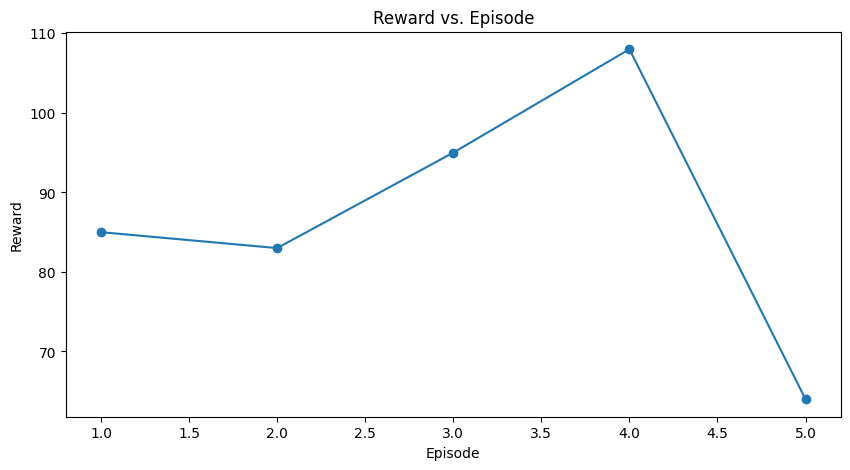

In [40]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 1, 1)  # 1 row, 2 columns, plot 1
plt.plot(episodes, rewards, marker='o')
plt.title('Reward vs. Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')

In [32]:
print(trainer.net.state_dict())

OrderedDict([('w_input', tensor([-1.6921,  0.8183,  2.2232,  0.3267])), ('w_output', tensor([101.8853, 103.1857])), ('q_layers.x_weights', tensor([[5.3530, 1.4473, 2.0395, 3.8794],
        [4.9187, 4.2459, 2.3673, 2.3853],
        [2.1600, 4.0161, 4.6574, 0.7586],
        [1.5512, 1.9853, 1.3821, 5.9766],
        [4.8708, 3.9906, 2.3892, 5.4725]])), ('q_layers.z_weights', tensor([[1.5830, 6.7343, 1.6780, 2.3363],
        [4.9383, 5.3691, 2.7014, 2.6552],
        [2.8806, 4.8582, 2.1814, 3.3162],
        [2.9944, 2.4515, 2.6691, 2.7286],
        [2.4491, 4.2660, 1.7833, 4.8850]]))])


In [31]:
!zip -r log.zip logs/

'zip' is not recognized as an internal or external command,
operable program or batch file.
